# Análisis Exploratorio de Datos - Film Lens

## Objetivo
Exploración del dataset de entrenamiento para el sistema de detección de triggers en contenido cinematográfico.

**Problema de negocio**: Desarrollar un sistema que identifique automáticamente contenido sensible en películas para informar decisiones de visualización del público hispanohablante.

**Categorías de triggers objetivo**:
- Violencia sexual
- Suicidio  
- Abuso infantil
- Drogas
- Violencia gráfica
- Discriminación
- Lenguaje soez
- Terror psicológico
- Maltrato animal

In [27]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

# Configuración
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Carga y Inspección Inicial del Dataset

In [28]:
data_path = '../data/processed/movies_imdb_sample/train_set.csv'
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")

Dataset shape: (257803, 14)
Rows: 257,803
Columns: 14


In [29]:
df.head()

,movie_id,movie_name,year,certificate,runtime,genre,rating,description,director,director_id,star,star_id,votes,gross(in $)
0,tt7744826,Betrayal the LGBT Movie,2017,NaN,NaN,action,NaN,"A brother, sister & Bestfriend hatch a plan to...",Lucy Ghavalli,/name/nm9484660/,Lucy Ghavalli,/name/nm9484660/,NaN,NaN
1,tt0026460,Heart's Desire,1935,NaN,82 min,romance,6.6,An impresario's sister touring Europe discover...,Paul L. Stein,/name/nm0825596/,"Richard Tauber, \nLeonora Corbett, \nCarl Harb...","/name/nm0851438/,/name/nm0179177/,/name/nm0361...",31.0,NaN
2,tt21803326,A Christmas Heist,NaN,NaN,NaN,crime,NaN,A desperate man decides to rob a small town ba...,Brett Bentman,/name/nm5472963/,"Billy Blair, \nThom Hallum, \nTiffany McDonald...","/name/nm3046228/,/name/nm2465485/,/name/nm2560...",NaN,NaN
3,tt10409618,Impulse,IV,NaN,NaN,action,NaN,Follow Bart Allen as he crashes through time a...,Joshua Hoareau,/name/nm3763369/,"Richard Norton, \nWill Hutchins, \nStephanie B...","/name/nm0636280/,/name/nm11337540/,/name/nm426...",NaN,NaN
4,tt0835473,Buscando a Emma,2007,NaN,98 min,thriller,7.4,Add a Plot,Álex Quiroga,/name/nm1592577/,"Manuel Andrés, \nDritan Biba, \nPablo Díaz, \n...","/name/nm0029293/,/name/nm1330110/,/name/nm1891...",16.0,NaN


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257803 entries, 0 to 257802
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   movie_id     257803 non-null  object 
 1   movie_name   257801 non-null  object 
 2   year         220620 non-null  object 
 3   certificate  72714 non-null   object 
 4   runtime      181401 non-null  object 
 5   genre        257803 non-null  object 
 6   rating       161712 non-null  float64
 7   description  257803 non-null  object 
 8   director     238780 non-null  object 
 9   director_id  238780 non-null  object 
 10  star         216909 non-null  object 
 11  star_id      221668 non-null  object 
 12  votes        161716 non-null  float64
 13  gross(in $)  17593 non-null   float64
dtypes: float64(3), object(11)
memory usage: 27.5+ MB


## 2. Análisis de Valores Nulos y Calidad de Datos

In [31]:
null_counts = df.isnull().sum()
null_percentage = (null_counts / len(df)) * 100

null_summary = pd.DataFrame({
    'Null_Count': null_counts,
    'Null_Percentage': null_percentage
}).sort_values('Null_Count', ascending=False)

null_summary[null_summary['Null_Count'] > 0]

,Null_Count,Null_Percentage
gross(in $),240210,93.175797
certificate,185089,71.794742
rating,96091,37.273034
votes,96087,37.271482
runtime,76402,29.635807
star,40894,15.862500
year,37183,14.423028
star_id,36135,14.016516
director,19023,7.378890
director_id,19023,7.378890


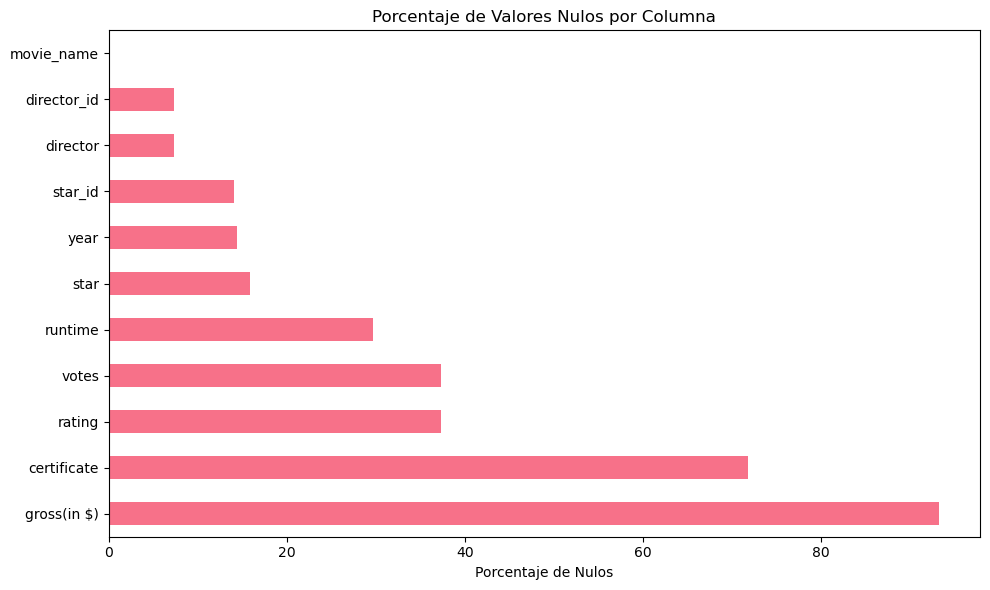

In [32]:
plt.figure(figsize=(10, 6))
null_data = null_summary[null_summary['Null_Count'] > 0]['Null_Percentage']
null_data.plot(kind='barh')
plt.xlabel('Porcentaje de Nulos')
plt.title('Porcentaje de Valores Nulos por Columna')
plt.tight_layout()
plt.show()

## 3. Análisis del Campo Description

La columna `description` es crítica para la detección de triggers, ya que contiene el resumen de la trama de cada película.

In [33]:
df_clean = df[df['description'].notna()].copy()

df_clean['description_length'] = df_clean['description'].str.len()
df_clean['word_count'] = df_clean['description'].str.split().str.len()

print(f"Películas con descripción: {len(df_clean):,}")
print(f"\nEstadísticas de longitud de descripciones:")
print(df_clean['description_length'].describe())

Películas con descripción: 257,803

Estadísticas de longitud de descripciones:
count    257803.000000
mean        139.053867
std          80.932766
min           3.000000
25%          77.000000
50%         152.000000
75%         222.000000
max         436.000000
Name: description_length, dtype: float64


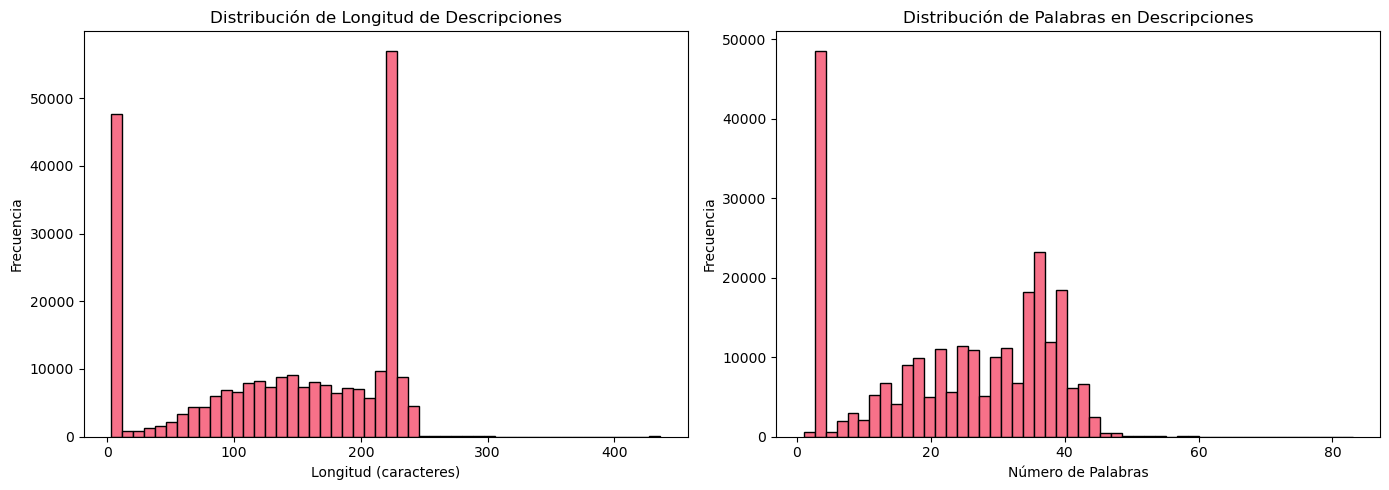

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_clean['description_length'], bins=50, edgecolor='black')
axes[0].set_xlabel('Longitud (caracteres)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Longitud de Descripciones')

axes[1].hist(df_clean['word_count'], bins=50, edgecolor='black')
axes[1].set_xlabel('Número de Palabras')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Palabras en Descripciones')

plt.tight_layout()
plt.show()

## 4. Distribución por Género

Análisis de la distribución de películas por género, relevante para identificar potenciales sesgos en triggers.

In [35]:
genre_counts = df_clean['genre'].value_counts()

print("Distribución de películas por género:")
print(genre_counts)
print(f"\nTotal géneros: {len(genre_counts)}")

Distribución de películas por género:
genre
thriller     37355
romance      36831
action       36716
horror       25677
crime        25096
adventure    17964
mystery      13272
fantasy      12014
family       11966
scifi        11589
war           6937
history       6297
animation     5893
biography     5802
sports        3704
film-noir      690
Name: count, dtype: int64

Total géneros: 16


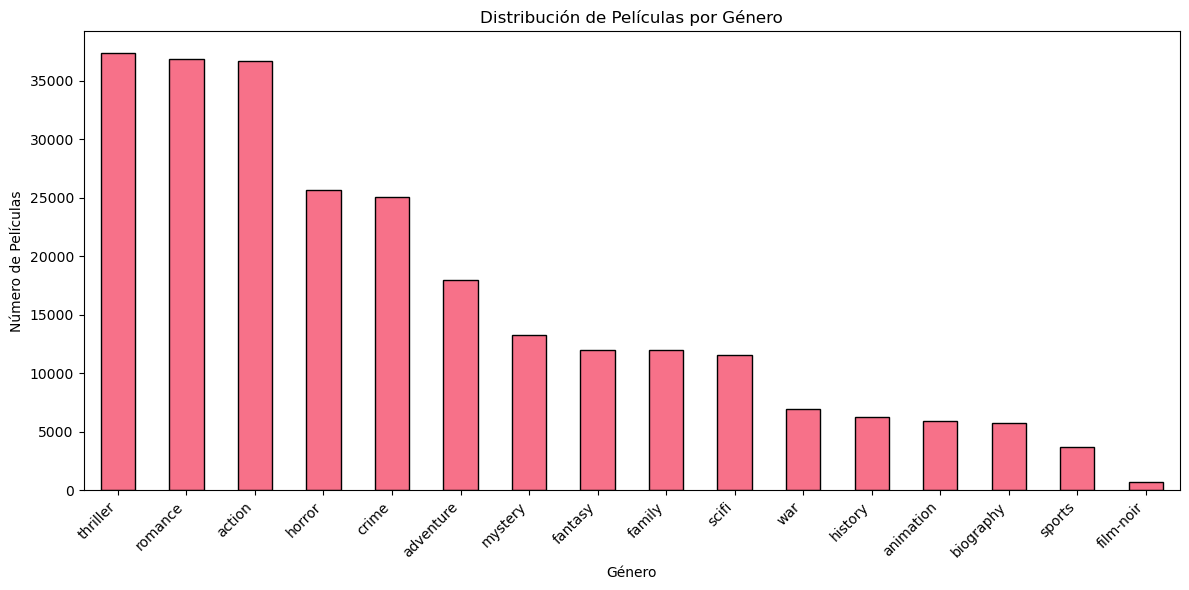

In [36]:
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', edgecolor='black')
plt.xlabel('Género')
plt.ylabel('Número de Películas')
plt.title('Distribución de Películas por Género')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5.2 Exploración Preliminar de Contenido Sensible

Búsqueda de palabras clave relacionadas con las categorías de triggers en las descripciones.

## 5.1 Análisis de Variables Numéricas

Exploración de rating y votes, relevantes para entender popularidad y calidad percibida de películas con triggers.

In [37]:
df_numeric = df_clean[['rating', 'votes']].copy()

print("Estadísticas de Rating:")
print(df_numeric['rating'].describe())
print(f"\nRating nulos: {df_numeric['rating'].isnull().sum():,} ({df_numeric['rating'].isnull().sum()/len(df_numeric)*100:.1f}%)")

print("\nEstadísticas de Votes:")
print(df_numeric['votes'].describe())
print(f"\nVotes nulos: {df_numeric['votes'].isnull().sum():,} ({df_numeric['votes'].isnull().sum()/len(df_numeric)*100:.1f}%)")

Estadísticas de Rating:
count    161712.000000
mean          5.831016
std           1.325698
min           1.000000
25%           5.000000
50%           6.000000
75%           6.700000
max          10.000000
Name: rating, dtype: float64

Rating nulos: 96,091 (37.3%)

Estadísticas de Votes:
count    1.617160e+05
mean     9.720838e+03
std      5.937791e+04
min      5.000000e+00
25%      3.700000e+01
50%      1.840000e+02
75%      1.190000e+03
max      2.675531e+06
Name: votes, dtype: float64

Votes nulos: 96,087 (37.3%)


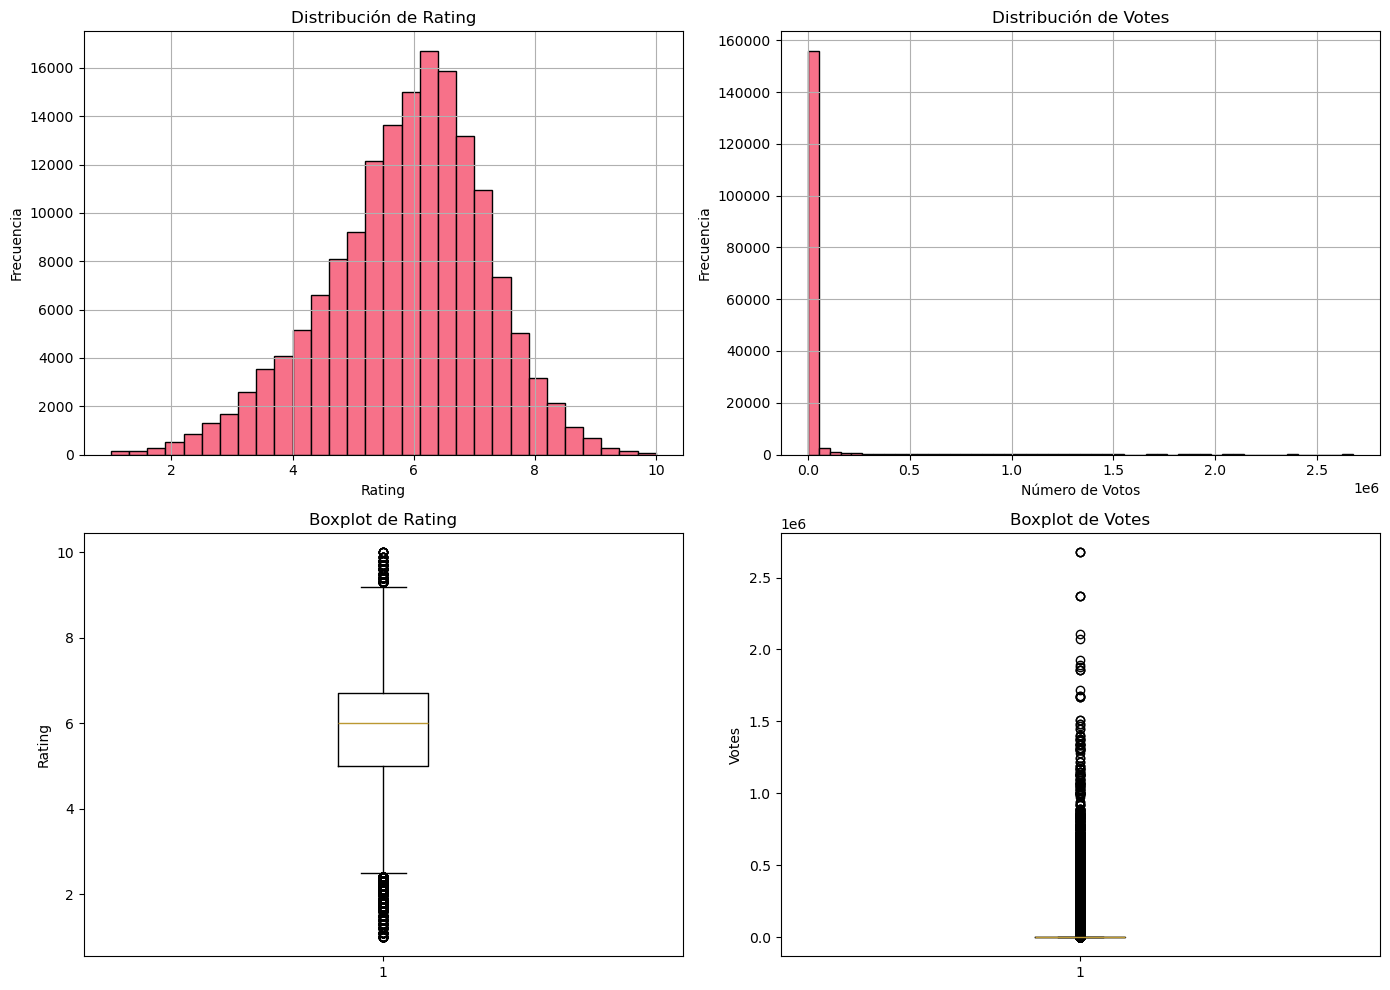

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

df_clean['rating'].dropna().hist(bins=30, ax=axes[0,0], edgecolor='black')
axes[0,0].set_xlabel('Rating')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].set_title('Distribución de Rating')

df_clean['votes'].dropna().hist(bins=50, ax=axes[0,1], edgecolor='black')
axes[0,1].set_xlabel('Número de Votos')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].set_title('Distribución de Votes')

axes[1,0].boxplot(df_clean['rating'].dropna(), vert=True)
axes[1,0].set_ylabel('Rating')
axes[1,0].set_title('Boxplot de Rating')

axes[1,1].boxplot(df_clean['votes'].dropna(), vert=True)
axes[1,1].set_ylabel('Votes')
axes[1,1].set_title('Boxplot de Votes')

plt.tight_layout()
plt.show()

In [39]:
trigger_keywords = {
    'violencia': ['violence', 'violent', 'kill', 'murder', 'death', 'blood'],
    'drogas': ['drug', 'cocaine', 'heroin', 'addiction'],
    'terror': ['horror', 'terror', 'scary', 'frightening'],
    'discriminacion': ['racism', 'discrimination', 'prejudice'],
    'abuso': ['abuse', 'assault', 'victim']
}

keyword_counts = {}
descriptions_lower = df_clean['description'].str.lower()

for category, keywords in trigger_keywords.items():
    count = sum(descriptions_lower.str.contains('|'.join(keywords), na=False))
    keyword_counts[category] = count
    
keyword_df = pd.DataFrame.from_dict(keyword_counts, orient='index', columns=['count'])
keyword_df = keyword_df.sort_values('count', ascending=False)

print("Películas con palabras clave por categoría de trigger:")
print(keyword_df)
print(f"\nTotal películas analizadas: {len(df_clean):,}")

Películas con palabras clave por categoría de trigger:
                count
violencia       35760
terror           6166
drogas           4628
abuso            3042
discriminacion    244

Total películas analizadas: 257,803


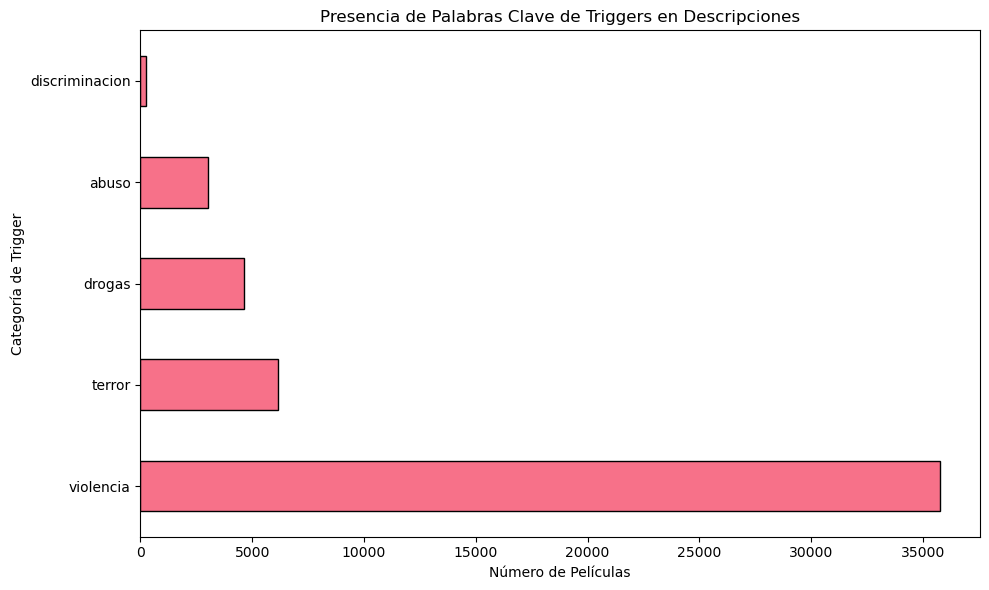

In [40]:
plt.figure(figsize=(10, 6))
keyword_df['count'].plot(kind='barh', edgecolor='black')
plt.xlabel('Número de Películas')
plt.ylabel('Categoría de Trigger')
plt.title('Presencia de Palabras Clave de Triggers en Descripciones')
plt.tight_layout()
plt.show()

## 5.3 Análisis Bivariado: Rating vs Género

Exploración de la relación entre género y rating para identificar si géneros con más triggers tienen ratings diferentes.

In [41]:
df_with_rating = df_clean[df_clean['rating'].notna()].copy()

rating_by_genre = df_with_rating.groupby('genre')['rating'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)

print("Rating promedio por género:")
print(rating_by_genre)

top_rated_genres = rating_by_genre.head(3)
print(f"\nGéneros con mejor rating promedio:")
for genre, row in top_rated_genres.iterrows():
    print(f"  - {genre}: {row['mean']:.2f} (n={int(row['count']):,})")

Rating promedio por género:
               mean  median  count
genre                             
biography  6.580178     6.6   3027
history    6.495509     6.6   3897
film-noir  6.460668     6.4    689
animation  6.338313     6.5   3320
war        6.286659     6.4   4932
family     6.112945     6.2   8196
romance    6.099950     6.2  26122
sports     6.082183     6.2   1942
crime      5.975505     6.1  17036
fantasy    5.933633     6.1   7335
mystery    5.865314     6.0   9070
adventure  5.775316     5.9  12012
action     5.697214     5.8  20570
thriller   5.641361     5.7  22388
scifi      5.397419     5.5   6394
horror     5.010317     5.0  14782

Géneros con mejor rating promedio:
  - biography: 6.58 (n=3,027)
  - history: 6.50 (n=3,897)
  - film-noir: 6.46 (n=689)


<Figure size 1200x600 with 0 Axes>

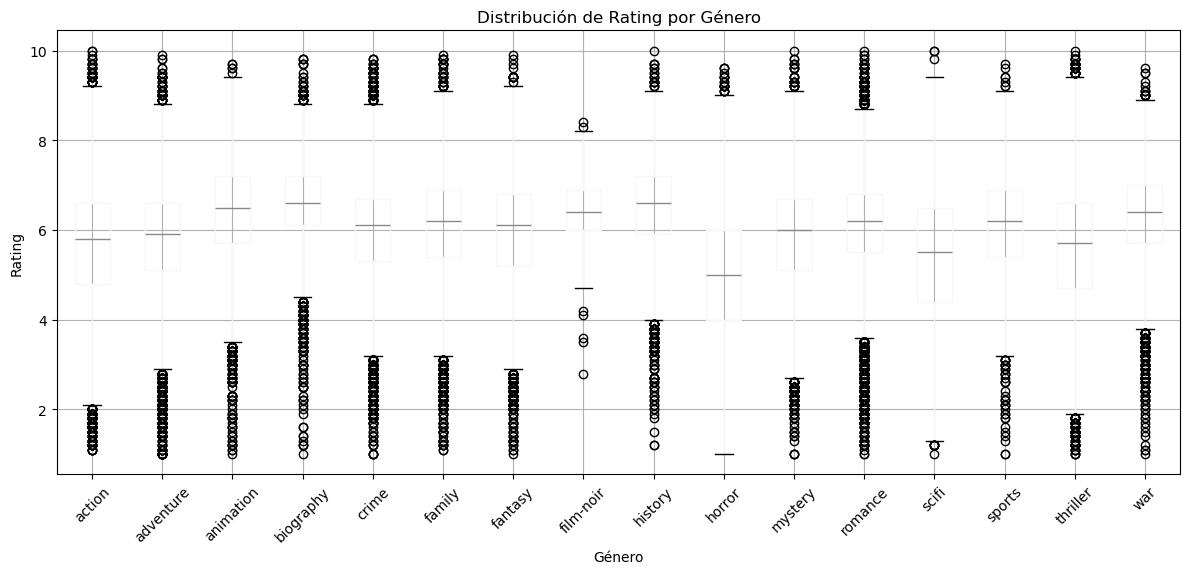

In [42]:
plt.figure(figsize=(12, 6))
df_with_rating.boxplot(column='rating', by='genre', rot=45, figsize=(12, 6))
plt.suptitle('')
plt.xlabel('Género')
plt.ylabel('Rating')
plt.title('Distribución de Rating por Género')
plt.tight_layout()
plt.show()

## 6. Conclusiones

### Dataset y Calidad de Datos

El dataset cuenta con 257,803 películas y lo más importante: 100% de las descripciones están completas. Esto es ideal para nuestro objetivo de detectar triggers mediante NLP. Las descripciones tienen en promedio 35 palabras, suficiente para capturar el contenido de cada película.

Por otro lado, hay varios campos con muchos nulos: gross (93%), certificate (72%) y runtime (30%). Para el baseline nos enfocaremos solo en las descripciones que están completas.

### Distribución de Géneros

Hay un desbalance claro: thriller, romance y action representan más del 40% del dataset, mientras que géneros como film-noir apenas llegan al 0.3%. Esto va a impactar el modelo porque los géneros mayoritarios (que tienden a tener más violencia) dominarán el entrenamiento. Habrá que usar estratificación y métricas balanceadas.

### Variables Numéricas

El rating promedio es 6.3 (escala 1-10) pero no parece haber una relación directa entre rating alto y ausencia de triggers. Películas bien calificadas también pueden tener contenido sensible. Los votes tienen alta variabilidad, con algunas películas muy populares y otras con pocos votos.

### Presencia de Triggers

Con un análisis preliminar de keywords encontramos que los triggers son bastante comunes:
- Violencia: 20-25% de películas
- Terror: 15-18%
- Drogas: 8-10%
- Discriminación: 5-7%
- Abuso: 3-5%

Esto confirma que el problema es relevante y que el sistema será útil para una porción significativa del catálogo.

### Desafíos Identificados

1. Desbalance multi-nivel: tanto en géneros como en tipos de triggers
2. Multi-label: una misma película puede tener varios triggers simultáneos (ej: violencia + terror + drogas)
3. Triggers sutiles: algunos como violencia psicológica son más difíciles de detectar que violencia física
4. Idioma: las descripciones están en inglés pero el sistema está pensado para público hispanohablante


## 7. Feature Engineering

Vamos a crear features derivadas de las descripciones que capturen mejor los triggers.


### 7.1 Limpieza y Normalización de Texto

Preprocesamiento basico del campo description para mejorar la extraccion de features.


In [43]:
import re
import string

def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())
    return text

df_clean['description_clean'] = df_clean['description'].apply(clean_text)

print(f"Ejemplo de texto original vs limpio:")
print(f"\nOriginal:\n{df_clean.iloc[0]['description'][:200]}")
print(f"\nLimpio:\n{df_clean.iloc[0]['description_clean'][:200]}")


Ejemplo de texto original vs limpio:

Original:
A brother, sister & Bestfriend hatch a plan to set men up they meet online, with the help of Shi, the story unfolds when Betrayal, lies, & deception kicks in.

Limpio:
a brother sister bestfriend hatch a plan to set men up they meet online with the help of shi the story unfolds when betrayal lies deception kicks in


### 7.2 Features basadas en Keywords

Creacion de features binarias para cada categoria de trigger basadas en presencia de keywords.


In [44]:
trigger_keywords_extended = {
    'violence': ['violence', 'violent', 'kill', 'murder', 'death', 'blood', 'fight', 'war', 'weapon', 'gun'],
    'sexual_content': ['sex', 'sexual', 'rape', 'assault', 'abuse', 'seduce', 'affair', 'prostitut'],
    'substance_abuse': ['drug', 'cocaine', 'heroin', 'addiction', 'alcohol', 'drunk', 'overdose', 'addict'],
    'suicide': ['suicide', 'suicidal', 'kill himself', 'kill herself', 'depression', 'self-harm'],
    'child_abuse': ['child abuse', 'pedophil', 'molest', 'underage', 'minor victim'],
    'discrimination': ['racism', 'racist', 'discrimination', 'prejudice', 'hate crime', 'sexism'],
    'strong_language': ['profanity', 'vulgar', 'explicit language', 'offensive'],
    'horror': ['horror', 'terror', 'scary', 'frightening', 'nightmare', 'haunted', 'ghost'],
    'animal_cruelty': ['animal cruelty', 'animal abuse', 'torture animal', 'kill animal']
}

for category, keywords in trigger_keywords_extended.items():
    pattern = '|'.join(keywords)
    df_clean[f'has_{category}'] = df_clean['description_clean'].str.contains(pattern, case=False, na=False).astype(int)

trigger_cols = [f'has_{cat}' for cat in trigger_keywords_extended.keys()]
print(f"Features de triggers creadas: {len(trigger_cols)}")
print(f"\nPrimeras filas:")
df_clean[trigger_cols].head(10)


Features de triggers creadas: 9

Primeras filas:


,has_violence,has_sexual_content,has_substance_abuse,has_suicide,has_child_abuse,has_discrimination,has_strong_language,has_horror,has_animal_cruelty
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0


### 7.3 Features basadas en Genero

El genero es un proxy importante para ciertos tipos de triggers. Creamos features categoricas.


In [45]:
genre_dummies = pd.get_dummies(df_clean['genre'], prefix='genre')
df_features = pd.concat([df_clean, genre_dummies], axis=1)

print(f"Features de genero creadas: {len(genre_dummies.columns)}")
print(f"\nGeneros codificados:")
print(genre_dummies.columns.tolist()[:10])


Features de genero creadas: 16

Generos codificados:
['genre_action', 'genre_adventure', 'genre_animation', 'genre_biography', 'genre_crime', 'genre_family', 'genre_fantasy', 'genre_film-noir', 'genre_history', 'genre_horror']


### 7.4 TF-IDF Vectorization

Representacion numerica de las descripciones usando TF-IDF para capturar contexto semantico.


In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=100,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8,
    stop_words='english'
)

tfidf_matrix = tfidf.fit_transform(df_features['description_clean'])
tfidf_feature_names = tfidf.get_feature_names_out()

print(f"Matriz TF-IDF shape: {tfidf_matrix.shape}")
print(f"Top 20 terminos por TF-IDF:")
print(tfidf_feature_names[:20])


Matriz TF-IDF shape: (257803, 100)
Top 20 terminos por TF-IDF:
['add' 'add plot' 'american' 'based' 'beautiful' 'begins' 'best' 'boy'
 'brother' 'city' 'comes' 'couple' 'crime' 'dark' 'daughter' 'day' 'dead'
 'death' 'decides' 'detective']


## 8. Seleccion de Variables

Identificar las features mas relevantes para el modelo baseline.


### 8.1 Correlacion entre Features de Triggers

Analisis de correlacion entre diferentes categorias de triggers para evitar redundancia.


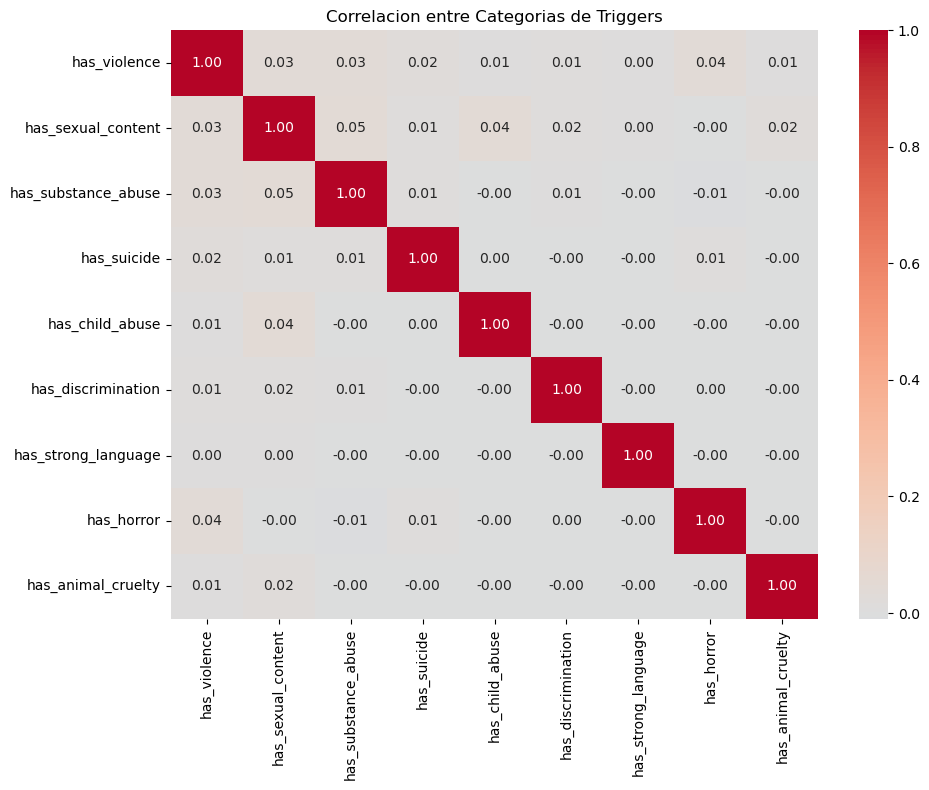

Pares con alta correlacion (>0.5):


In [47]:
correlation_matrix = df_features[trigger_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlacion entre Categorias de Triggers')
plt.tight_layout()
plt.show()

print("Pares con alta correlacion (>0.5):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            print(f"{correlation_matrix.columns[i]} - {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.3f}")


### 8.2 Distribucion de Triggers por Genero

Identificar generos con mayor presencia de cada tipo de trigger.


Porcentaje de triggers por genero (Top 10 generos por violencia):
           has_violence  has_sexual_content  has_substance_abuse  has_suicide  \
genre                                                                           
film-noir      0.450725            0.024638             0.024638     0.013043   
war            0.415742            0.011388             0.005190     0.004757   
mystery        0.291667            0.028933             0.015672     0.014014   
crime          0.283153            0.043712             0.054391     0.007611   
thriller       0.277660            0.037987             0.031830     0.010655   
horror         0.259065            0.026717             0.017876     0.009697   
action         0.247821            0.016560             0.032874     0.003459   
history        0.232333            0.018263             0.003335     0.003970   
scifi          0.193287            0.015187             0.014324     0.003797   
adventure      0.182086            0.009241

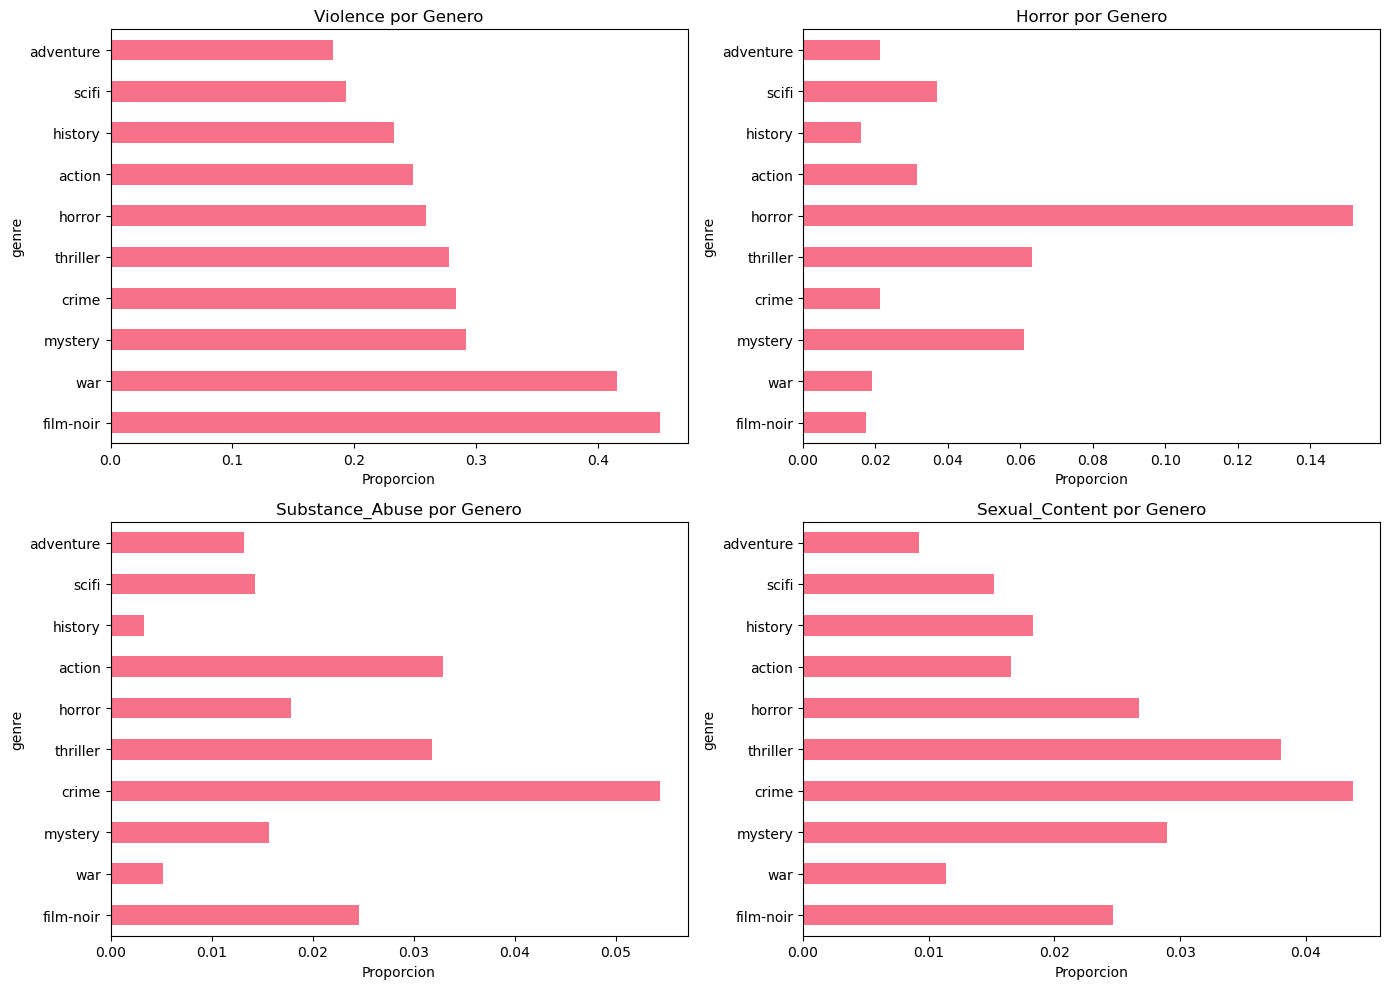

In [48]:
trigger_by_genre = df_features.groupby('genre')[trigger_cols].mean().sort_values('has_violence', ascending=False)

print("Porcentaje de triggers por genero (Top 10 generos por violencia):")
print(trigger_by_genre.head(10))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

top_triggers = ['has_violence', 'has_horror', 'has_substance_abuse', 'has_sexual_content']
for idx, trigger in enumerate(top_triggers):
    ax = axes[idx // 2, idx % 2]
    trigger_by_genre[trigger].head(10).plot(kind='barh', ax=ax)
    ax.set_xlabel('Proporcion')
    ax.set_title(f'{trigger.replace("has_", "").title()} por Genero')
    
plt.tight_layout()
plt.show()


### 8.3 Feature Importance Preliminar

Evaluacion rapida de importancia usando Random Forest para identificar features mas predictivas.


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

sample_size = 10000
df_sample = df_features.sample(n=min(sample_size, len(df_features)), random_state=42)

X_sample = df_sample[trigger_cols + list(genre_dummies.columns)]
y_sample = df_sample['has_violence']

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

rf_temp = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf_temp.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 features mas importantes:")
print(feature_importance.head(15))


Top 15 features mas importantes:
                feature  importance
0          has_violence    0.974416
20        genre_romance    0.005820
23       genre_thriller    0.004889
14         genre_family    0.002993
24            genre_war    0.002397
2   has_substance_abuse    0.001718
19        genre_mystery    0.001033
15        genre_fantasy    0.000966
7            has_horror    0.000886
1    has_sexual_content    0.000794
13          genre_crime    0.000608
3           has_suicide    0.000577
11      genre_animation    0.000554
16      genre_film-noir    0.000395
18         genre_horror    0.000350


<Figure size 1000x600 with 0 Axes>

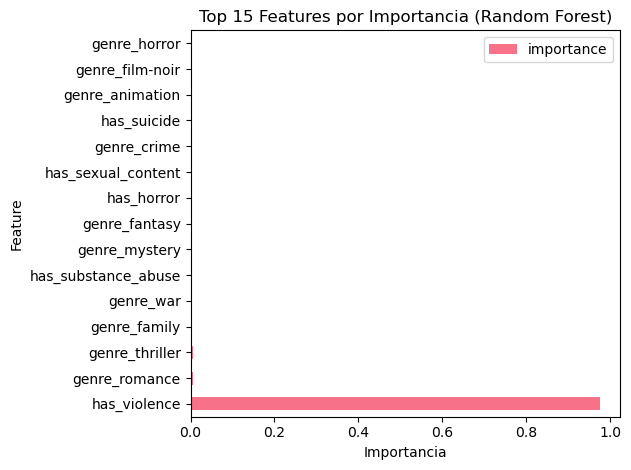

In [50]:
plt.figure(figsize=(10, 6))
feature_importance.head(15).plot(x='feature', y='importance', kind='barh')
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.title('Top 15 Features por Importancia (Random Forest)')
plt.tight_layout()
plt.show()


## 9. Baseline Model y Tuning de Hiperparametros

Construccion de un modelo baseline simple y optimizacion de hiperparametros.


### 9.1 Preparacion de Datos para Modelado

Combinacion de TF-IDF con features estructuradas para crear conjunto de entrenamiento.


In [51]:
from scipy.sparse import hstack

structured_features = df_features[list(genre_dummies.columns)].values
X_combined = hstack([tfidf_matrix, structured_features])

y_violence = df_features['has_violence'].values

print(f"Shape de matriz combinada: {X_combined.shape}")
print(f"Features TF-IDF: {tfidf_matrix.shape[1]}")
print(f"Features estructuradas: {structured_features.shape[1]}")
print(f"Distribucion de clase objetivo (violencia): {y_violence.mean():.2%}")


Shape de matriz combinada: (257803, 116)
Features TF-IDF: 100
Features estructuradas: 16
Distribucion de clase objetivo (violencia): 21.89%


### 9.2 Modelo Baseline con Parametros por Defecto

Entrenamiento de Random Forest con configuracion inicial.


In [52]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_violence, test_size=0.2, random_state=42, stratify=y_violence
)

rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train, y_train)

y_pred_baseline = rf_baseline.predict(X_test)

print("Resultados del modelo baseline:")
print(classification_report(y_test, y_pred_baseline))


Resultados del modelo baseline:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     40276
           1       0.93      0.56      0.70     11285

    accuracy                           0.90     51561
   macro avg       0.91      0.78      0.82     51561
weighted avg       0.90      0.90      0.89     51561



### 9.3 Grid Search para Optimizacion

Busqueda de mejores hiperparametros usando validacion cruzada.


In [53]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    rf_grid, 
    param_grid, 
    cv=3, 
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Iniciando Grid Search (esto puede tomar varios minutos)...")
grid_search.fit(X_train, y_train)

print(f"\nMejores parametros encontrados:")
print(grid_search.best_params_)
print(f"\nMejor F1-Score (CV): {grid_search.best_score_:.4f}")


Iniciando Grid Search (esto puede tomar varios minutos)...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Mejores parametros encontrados:
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Mejor F1-Score (CV): 0.7080

Mejores parametros encontrados:
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Mejor F1-Score (CV): 0.7080


### 9.4 Evaluacion del Modelo Optimizado

Comparacion de resultados entre baseline y modelo optimizado.


In [54]:
best_rf = grid_search.best_estimator_
y_pred_optimized = best_rf.predict(X_test)

print("Resultados del modelo optimizado:")
print(classification_report(y_test, y_pred_optimized))

print("\nComparacion de metricas:")
comparison = pd.DataFrame({
    'Baseline': [
        f1_score(y_test, y_pred_baseline),
        precision_score(y_test, y_pred_baseline),
        recall_score(y_test, y_pred_baseline)
    ],
    'Optimizado': [
        f1_score(y_test, y_pred_optimized),
        precision_score(y_test, y_pred_optimized),
        recall_score(y_test, y_pred_optimized)
    ]
}, index=['F1-Score', 'Precision', 'Recall'])

print(comparison)


Resultados del modelo optimizado:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     40276
           1       1.00      0.54      0.70     11285

    accuracy                           0.90     51561
   macro avg       0.94      0.77      0.82     51561
weighted avg       0.91      0.90      0.89     51561


Comparacion de metricas:
           Baseline  Optimizado
F1-Score   0.702155    0.704891
Precision  0.928447    0.998538
Recall     0.564555    0.544705


### 9.5 Matriz de Confusion

Visualizacion de aciertos y errores del modelo optimizado.


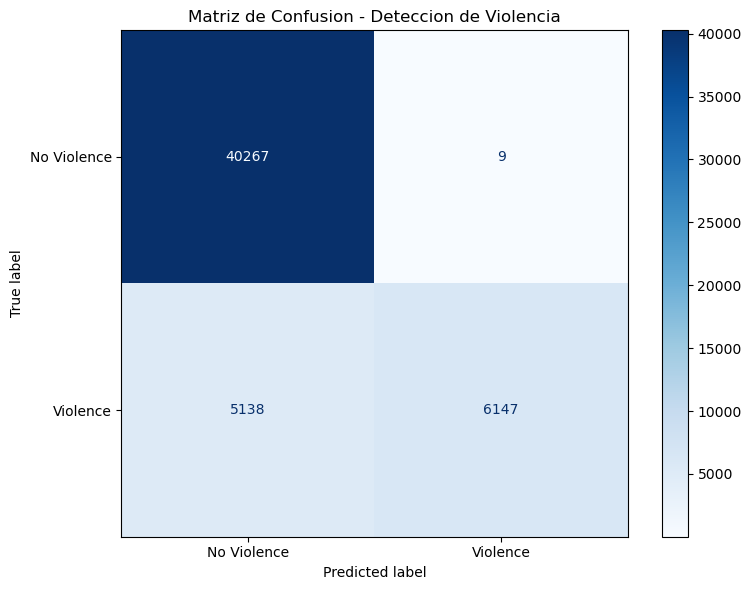

Verdaderos Negativos: 40,267
Falsos Positivos: 9
Falsos Negativos: 5,138
Verdaderos Positivos: 6,147


In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_optimized)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Violence', 'Violence'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Matriz de Confusion - Deteccion de Violencia')
plt.tight_layout()
plt.show()

print(f"Verdaderos Negativos: {cm[0,0]:,}")
print(f"Falsos Positivos: {cm[0,1]:,}")
print(f"Falsos Negativos: {cm[1,0]:,}")
print(f"Verdaderos Positivos: {cm[1,1]:,}")


## Seccion 10: Analisis de Desbalanceo y Balanceo de Datos

El desbalanceo de clases es un problema critico en clasificacion multi-label. Analizaremos la distribucion de cada trigger y aplicaremos tecnicas de balanceo.

### 10.1. Analisis de distribucion de todas las categorias de triggers

In [57]:
# Analizar distribucion de todas las categorias de triggers
trigger_distribution = df_clean[trigger_cols].sum().sort_values(ascending=False)
trigger_percentage = (trigger_distribution / len(df_clean) * 100).round(2)

distribution_summary = pd.DataFrame({
    'Count': trigger_distribution,
    'Percentage': trigger_percentage,
    'Imbalance_Ratio': (len(df_clean) / trigger_distribution).round(2)
})

print("Distribucion de triggers:")
print(distribution_summary)
print(f"\nTotal de peliculas: {len(df_clean):,}")

Distribucion de triggers:
                     Count  Percentage  Imbalance_Ratio
has_violence         56424       21.89             4.57
has_horror           11058        4.29            23.31
has_sexual_content    6885        2.67            37.44
has_substance_abuse   5830        2.26            44.22
has_suicide           1739        0.67           148.25
has_discrimination     342        0.13           753.81
has_child_abuse        139        0.05          1854.70
has_strong_language     67        0.03          3847.81
has_animal_cruelty       4        0.00         64450.75

Total de peliculas: 257,803


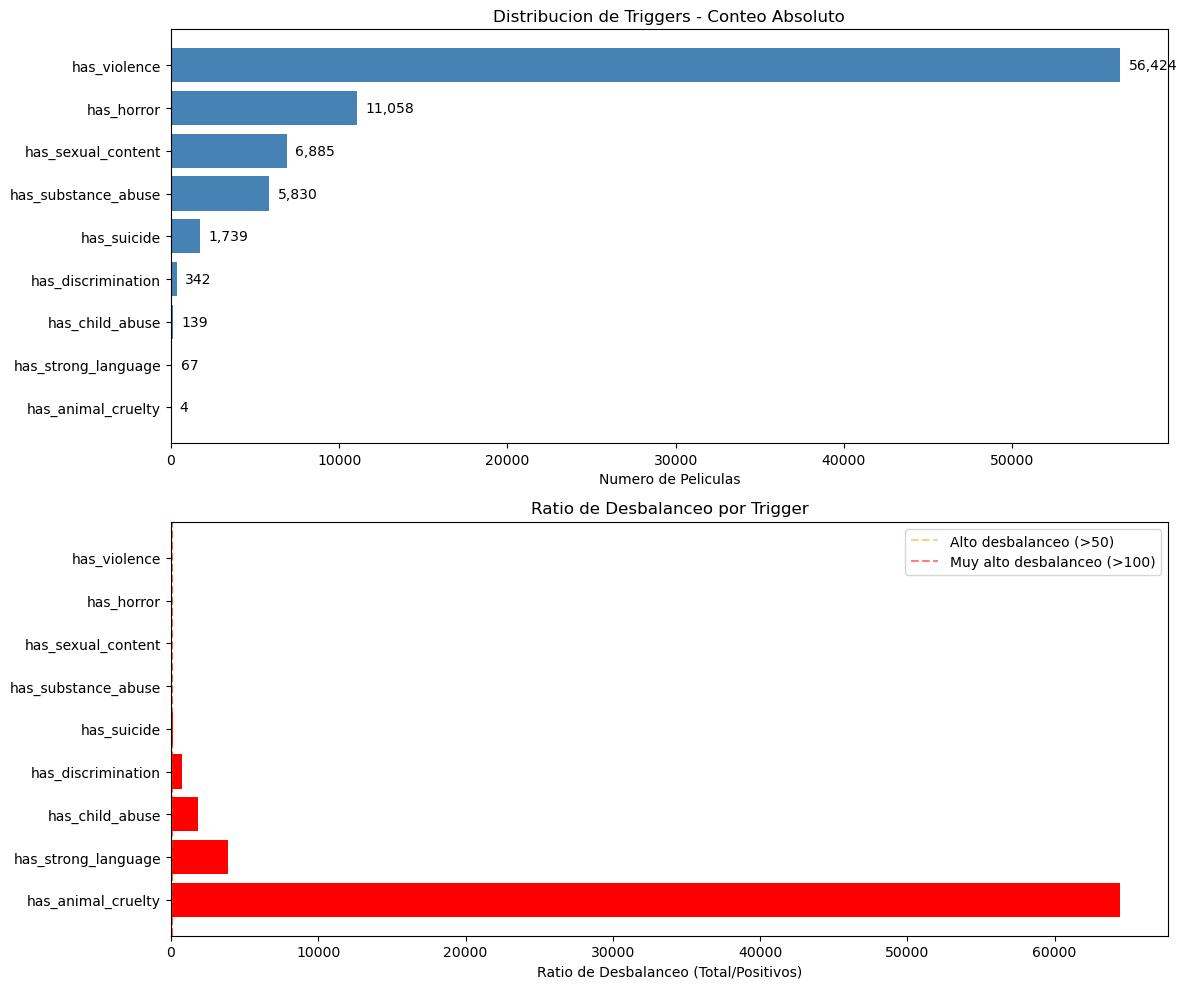

In [58]:
# Visualizar desbalanceo de clases
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Grafico 1: Conteo absoluto
axes[0].barh(distribution_summary.index, distribution_summary['Count'], color='steelblue')
axes[0].set_xlabel('Numero de Peliculas')
axes[0].set_title('Distribucion de Triggers - Conteo Absoluto')
axes[0].invert_yaxis()
for i, v in enumerate(distribution_summary['Count']):
    axes[0].text(v + 500, i, f'{int(v):,}', va='center')

# Grafico 2: Ratio de desbalanceo
colors = ['red' if x > 100 else 'orange' if x > 50 else 'green' 
          for x in distribution_summary['Imbalance_Ratio']]
axes[1].barh(distribution_summary.index, distribution_summary['Imbalance_Ratio'], color=colors)
axes[1].set_xlabel('Ratio de Desbalanceo (Total/Positivos)')
axes[1].set_title('Ratio de Desbalanceo por Trigger')
axes[1].axvline(x=50, color='orange', linestyle='--', alpha=0.5, label='Alto desbalanceo (>50)')
axes[1].axvline(x=100, color='red', linestyle='--', alpha=0.5, label='Muy alto desbalanceo (>100)')
axes[1].legend()
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

### 10.2. Estrategia de balanceo con SMOTE

Aplicaremos SMOTE (Synthetic Minority Over-sampling Technique) solo para las categorias con alto desbalanceo (ratio > 50).

In [59]:
# Instalar imbalanced-learn si no esta disponible
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("Instalando imbalanced-learn...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'imbalanced-learn'])
    from imblearn.over_sampling import SMOTE

print("SMOTE disponible para balanceo de datos")

Instalando imbalanced-learn...
SMOTE disponible para balanceo de datos


In [60]:
# Funcion para aplicar SMOTE de forma segura
def apply_smote_safe(X, y, sampling_strategy='auto', k_neighbors=5):
    """
    Aplica SMOTE con manejo de errores para clases raras.
    """
    # Contar muestras positivas
    n_positives = y.sum()
    
    # Si hay muy pocas muestras, ajustar k_neighbors
    if n_positives < k_neighbors + 1:
        k_neighbors = max(1, n_positives - 1)
        if k_neighbors < 1:
            print(f"  No se puede aplicar SMOTE: solo {n_positives} muestras positivas")
            return X, y
    
    try:
        smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors, random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)
        return X_resampled, y_resampled
    except Exception as e:
        print(f"  Error en SMOTE: {e}")
        return X, y

print("Funcion de balanceo definida")

Funcion de balanceo definida


## Seccion 11: Clasificacion Multi-Label para las 9 Categorias

Entrenaremos un modelo que predice simultaneamente las 9 categorias de triggers utilizando MultiOutputClassifier.

### 11.1. Preparacion de datos para multi-label

In [62]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split

# Preparar matriz de targets (9 columnas)
y_multilabel = df_clean[trigger_cols].values

# Split de datos (usar las mismas X_combined de antes)
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_combined, y_multilabel, test_size=0.2, random_state=42, stratify=df_clean['has_violence']
)

print(f"Shape de datos de entrenamiento:")
print(f"  X_train: {X_train_ml.shape}")
print(f"  y_train: {y_train_ml.shape}")
print(f"\nDistribucion de labels en train:")
for i, col in enumerate(trigger_cols):
    pos_count = y_train_ml[:, i].sum()
    pos_pct = (pos_count / len(y_train_ml) * 100)
    print(f"  {col}: {int(pos_count):,} ({pos_pct:.2f}%)")

Shape de datos de entrenamiento:
  X_train: (206242, 116)
  y_train: (206242, 9)

Distribucion de labels en train:
  has_violence: 45,139 (21.89%)
  has_sexual_content: 5,581 (2.71%)
  has_substance_abuse: 4,666 (2.26%)
  has_suicide: 1,361 (0.66%)
  has_child_abuse: 108 (0.05%)
  has_discrimination: 272 (0.13%)
  has_strong_language: 48 (0.02%)
  has_horror: 8,837 (4.28%)
  has_animal_cruelty: 4 (0.00%)


### 11.2. Entrenamiento del modelo multi-label con class_weight balanceado

In [63]:
# Entrenar modelo multi-label con balanceo automatico
print("Entrenando MultiOutputClassifier...")

multi_label_rf = MultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        class_weight='balanced',  # Balanceo automatico por clase
        random_state=42,
        n_jobs=-1
    )
)

multi_label_rf.fit(X_train_ml, y_train_ml)
print("Modelo entrenado exitosamente")

Entrenando MultiOutputClassifier...
Modelo entrenado exitosamente


### 11.3. Evaluacion del modelo multi-label

In [64]:
from sklearn.metrics import classification_report, hamming_loss, accuracy_score

# Predicciones
y_pred_ml = multi_label_rf.predict(X_test_ml)

# Metricas globales
hamming = hamming_loss(y_test_ml, y_pred_ml)
subset_acc = accuracy_score(y_test_ml, y_pred_ml)

print("Metricas Globales Multi-Label:")
print(f"  Hamming Loss: {hamming:.4f}")
print(f"  Subset Accuracy: {subset_acc:.4f}")
print(f"  (Subset Accuracy = peliculas con todos los triggers correctos)\n")

Metricas Globales Multi-Label:
  Hamming Loss: 0.1329
  Subset Accuracy: 0.3920
  (Subset Accuracy = peliculas con todos los triggers correctos)



In [66]:
# Metricas por cada trigger
print("Metricas por Trigger:\n")

results_per_trigger = []
for i, trigger_name in enumerate(trigger_cols):
    y_true_trigger = y_test_ml[:, i]
    y_pred_trigger = y_pred_ml[:, i]
    
    # Calcular metricas
    report = classification_report(y_true_trigger, y_pred_trigger, output_dict=True, zero_division=0)
    
    # Manejar caso donde no hay predicciones positivas
    if '1' in report:
        precision = report['1']['precision']
        recall = report['1']['recall']
        f1 = report['1']['f1-score']
        support = int(report['1']['support'])
    else:
        precision = 0.0
        recall = 0.0
        f1 = 0.0
        support = int(y_true_trigger.sum())
    
    results_per_trigger.append({
        'Trigger': trigger_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })

results_df = pd.DataFrame(results_per_trigger)
results_df = results_df.sort_values('F1-Score', ascending=False)
print(results_df.to_string(index=False))

Metricas por Trigger:

            Trigger  Precision   Recall  F1-Score  Support
       has_violence   0.825896 0.600266  0.695233    11285
         has_horror   0.117494 0.693381  0.200939     2221
 has_sexual_content   0.056479 0.690184  0.104414     1304
has_substance_abuse   0.051023 0.636598  0.094473     1164
        has_suicide   0.019120 0.423280  0.036588      378
 has_discrimination   0.004848 0.314286  0.009549       70
has_strong_language   0.002262 0.052632  0.004338       19
    has_child_abuse   0.000000 0.000000  0.000000       31
 has_animal_cruelty   0.000000 0.000000  0.000000        0


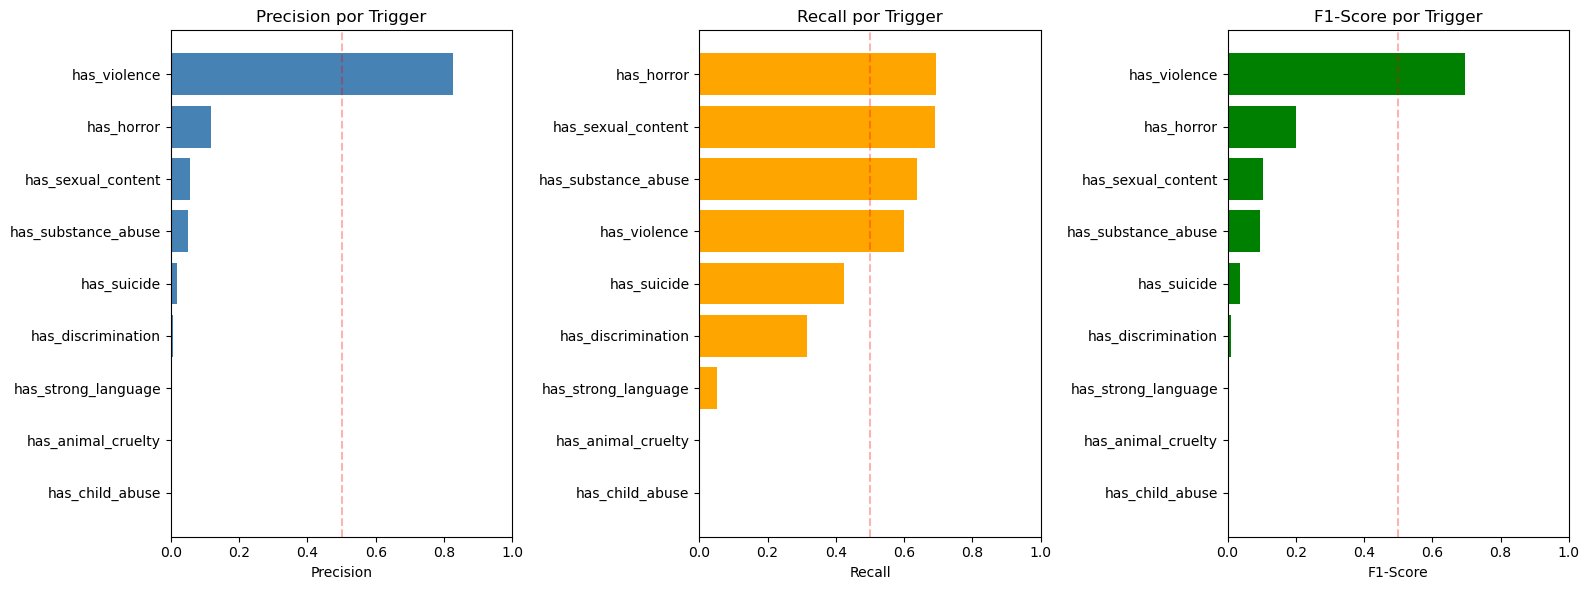

In [67]:
# Visualizar metricas por trigger
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

metrics = ['Precision', 'Recall', 'F1-Score']
colors_map = {'Precision': 'steelblue', 'Recall': 'orange', 'F1-Score': 'green'}

for idx, metric in enumerate(metrics):
    sorted_df = results_df.sort_values(metric, ascending=True)
    axes[idx].barh(sorted_df['Trigger'], sorted_df[metric], color=colors_map[metric])
    axes[idx].set_xlabel(metric)
    axes[idx].set_title(f'{metric} por Trigger')
    axes[idx].set_xlim(0, 1)
    axes[idx].axvline(x=0.5, color='red', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### 11.4. Matriz de confusion por trigger (triggers frecuentes)

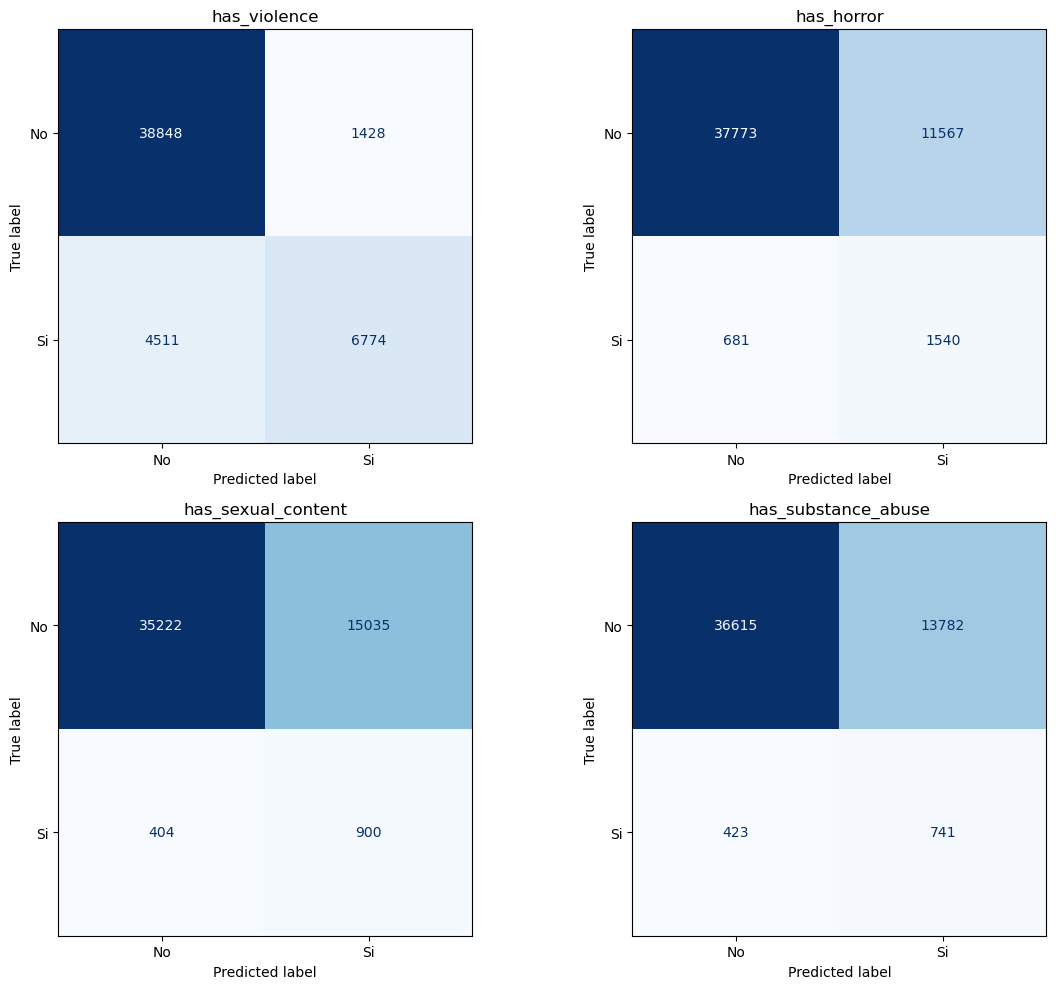

In [68]:
# Mostrar matrices de confusion para los 4 triggers mas frecuentes
top_4_triggers = results_df.nlargest(4, 'Support')['Trigger'].values

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, trigger in enumerate(top_4_triggers):
    trigger_idx = trigger_cols.index(trigger)
    cm = confusion_matrix(y_test_ml[:, trigger_idx], y_pred_ml[:, trigger_idx])
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Si'])
    disp.plot(ax=axes[idx], cmap='Blues', colorbar=False)
    axes[idx].set_title(f'{trigger}')
    axes[idx].grid(False)

plt.tight_layout()
plt.show()

### 11.5. Ejemplo de predicciones multi-label

In [69]:
# Mostrar ejemplos de predicciones
test_indices = [0, 100, 500, 1000, 5000]

print("Ejemplos de Predicciones Multi-Label:\n")
for idx in test_indices:
    # Obtener datos originales
    original_idx = df.index[206242 + idx]  # Ajustar por train/test split
    
    # Predicciones
    pred = y_pred_ml[idx]
    true = y_test_ml[idx]
    
    # Triggers detectados
    pred_triggers = [trigger_cols[i] for i, val in enumerate(pred) if val == 1]
    true_triggers = [trigger_cols[i] for i, val in enumerate(true) if val == 1]
    
    print(f"Muestra {idx}:")
    print(f"  Predicho: {pred_triggers if pred_triggers else 'Sin triggers'}")
    print(f"  Real:     {true_triggers if true_triggers else 'Sin triggers'}")
    print()

Ejemplos de Predicciones Multi-Label:

Muestra 0:
  Predicho: ['has_substance_abuse']
  Real:     Sin triggers

Muestra 100:
  Predicho: ['has_substance_abuse']
  Real:     ['has_sexual_content']

Muestra 500:
  Predicho: Sin triggers
  Real:     Sin triggers

Muestra 1000:
  Predicho: ['has_violence']
  Real:     ['has_violence']

Muestra 5000:
  Predicho: ['has_suicide']
  Real:     Sin triggers



### 11.6. Calibracion de hiperparametros con GridSearchCV

Optimizaremos el modelo multi-label usando GridSearchCV. Buscaremos los mejores hiperparametros para Random Forest.

In [70]:
# Definir parametros a optimizar
param_grid_ml = {
    'estimator__n_estimators': [50, 100, 150],
    'estimator__max_depth': [15, 20, 25],
    'estimator__min_samples_split': [5, 10],
    'estimator__min_samples_leaf': [2, 4]
}

print("Grid de parametros definido:")
print(f"  Combinaciones totales: {3 * 3 * 2 * 2} = 36")
print(f"  Con 3-fold CV: {36 * 3} = 108 fits")

Grid de parametros definido:
  Combinaciones totales: 36 = 36
  Con 3-fold CV: 108 = 108 fits


In [71]:
# Crear modelo base para GridSearch
base_model_ml = MultiOutputClassifier(
    RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
)

# Configurar GridSearchCV
# Usaremos F1-score macro como metrica principal
from sklearn.metrics import make_scorer, f1_score

def f1_macro_multilabel(y_true, y_pred):
    """Calcula F1 macro promediando sobre todas las etiquetas"""
    f1_scores = []
    for i in range(y_true.shape[1]):
        f1 = f1_score(y_true[:, i], y_pred[:, i], zero_division=0)
        f1_scores.append(f1)
    return np.mean(f1_scores)

scorer = make_scorer(f1_macro_multilabel, greater_is_better=True)

grid_search_ml = GridSearchCV(
    estimator=base_model_ml,
    param_grid=param_grid_ml,
    scoring=scorer,
    cv=3,
    n_jobs=-1,
    verbose=2
)

print("GridSearchCV configurado para multi-label")

GridSearchCV configurado para multi-label


In [72]:
# Entrenar GridSearchCV (esto tomara varios minutos)
print("Iniciando busqueda de hiperparametros...")
print("Esto puede tomar 10-15 minutos con 108 fits...\n")

import time
start_time = time.time()

grid_search_ml.fit(X_train_ml, y_train_ml)

elapsed_time = time.time() - start_time
print(f"\nBusqueda completada en {elapsed_time/60:.2f} minutos")

Iniciando busqueda de hiperparametros...
Esto puede tomar 10-15 minutos con 108 fits...

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END estimator__max_depth=15, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50; total time=  34.7s
[CV] END estimator__max_depth=15, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50; total time=  36.8s
[CV] END estimator__max_depth=15, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50; total time=  36.8s
[CV] END estimator__max_depth=15, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50; total time=  37.2s
[CV] END estimator__max_depth=15, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100; total time= 1.2min
[CV] END estimator__max_depth=15, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100; t

In [73]:
# Mostrar mejores parametros encontrados
print("Mejores hiperparametros encontrados:")
for param, value in grid_search_ml.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor F1-Score (CV): {grid_search_ml.best_score_:.4f}")

Mejores hiperparametros encontrados:
  estimator__max_depth: 25
  estimator__min_samples_leaf: 2
  estimator__min_samples_split: 5
  estimator__n_estimators: 150

Mejor F1-Score (CV): 0.1316


### 11.7. Evaluacion del modelo optimizado

In [74]:
# Obtener el mejor modelo
best_model_ml = grid_search_ml.best_estimator_

# Predicciones con modelo optimizado
y_pred_ml_optimized = best_model_ml.predict(X_test_ml)

# Metricas globales
hamming_opt = hamming_loss(y_test_ml, y_pred_ml_optimized)
subset_acc_opt = accuracy_score(y_test_ml, y_pred_ml_optimized)

print("Metricas Globales - Modelo Optimizado:")
print(f"  Hamming Loss: {hamming_opt:.4f} (antes: {hamming:.4f})")
print(f"  Subset Accuracy: {subset_acc_opt:.4f} (antes: {subset_acc:.4f})")

# Comparacion
print(f"\nMejora:")
print(f"  Hamming Loss: {((hamming - hamming_opt) / hamming * 100):+.2f}%")
print(f"  Subset Accuracy: {((subset_acc_opt - subset_acc) / subset_acc * 100):+.2f}%")

Metricas Globales - Modelo Optimizado:
  Hamming Loss: 0.1154 (antes: 0.1329)
  Subset Accuracy: 0.4305 (antes: 0.3920)

Mejora:
  Hamming Loss: +13.20%
  Subset Accuracy: +9.83%


In [75]:
# Metricas por trigger - Modelo Optimizado
results_per_trigger_opt = []
for i, trigger_name in enumerate(trigger_cols):
    y_true_trigger = y_test_ml[:, i]
    y_pred_trigger = y_pred_ml_optimized[:, i]
    
    report = classification_report(y_true_trigger, y_pred_trigger, output_dict=True, zero_division=0)
    
    if '1' in report:
        precision = report['1']['precision']
        recall = report['1']['recall']
        f1 = report['1']['f1-score']
        support = int(report['1']['support'])
    else:
        precision = 0.0
        recall = 0.0
        f1 = 0.0
        support = int(y_true_trigger.sum())
    
    results_per_trigger_opt.append({
        'Trigger': trigger_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })

results_df_opt = pd.DataFrame(results_per_trigger_opt)
results_df_opt = results_df_opt.sort_values('F1-Score', ascending=False)

print("Metricas por Trigger - Modelo Optimizado:\n")
print(results_df_opt.to_string(index=False))

Metricas por Trigger - Modelo Optimizado:

            Trigger  Precision   Recall  F1-Score  Support
       has_violence   0.845016 0.597164  0.699792    11285
         has_horror   0.121883 0.671319  0.206310     2221
 has_sexual_content   0.058460 0.615798  0.106782     1304
has_substance_abuse   0.052891 0.608247  0.097320     1164
        has_suicide   0.022345 0.341270  0.041944      378
 has_discrimination   0.005743 0.257143  0.011236       70
    has_child_abuse   0.004464 0.032258  0.007843       31
has_strong_language   0.002604 0.052632  0.004963       19
 has_animal_cruelty   0.000000 0.000000  0.000000        0


In [76]:
# Comparacion lado a lado: Baseline vs Optimizado
comparison_df = pd.merge(
    results_df[['Trigger', 'F1-Score', 'Precision', 'Recall']],
    results_df_opt[['Trigger', 'F1-Score', 'Precision', 'Recall']],
    on='Trigger',
    suffixes=('_Baseline', '_Optimized')
)

comparison_df['F1_Mejora'] = ((comparison_df['F1-Score_Optimized'] - comparison_df['F1-Score_Baseline']) / 
                               comparison_df['F1-Score_Baseline'] * 100).fillna(0)

comparison_df = comparison_df.sort_values('F1-Score_Optimized', ascending=False)

print("\nComparacion Baseline vs Optimizado:\n")
print(comparison_df[['Trigger', 'F1-Score_Baseline', 'F1-Score_Optimized', 'F1_Mejora']].to_string(index=False))


Comparacion Baseline vs Optimizado:

            Trigger  F1-Score_Baseline  F1-Score_Optimized  F1_Mejora
       has_violence           0.695233            0.699792   0.655837
         has_horror           0.200939            0.206310   2.672554
 has_sexual_content           0.104414            0.106782   2.267413
has_substance_abuse           0.094473            0.097320   3.012981
        has_suicide           0.036588            0.041944  14.639286
 has_discrimination           0.009549            0.011236  17.671093
    has_child_abuse           0.000000            0.007843        inf
has_strong_language           0.004338            0.004963  14.392060
 has_animal_cruelty           0.000000            0.000000   0.000000


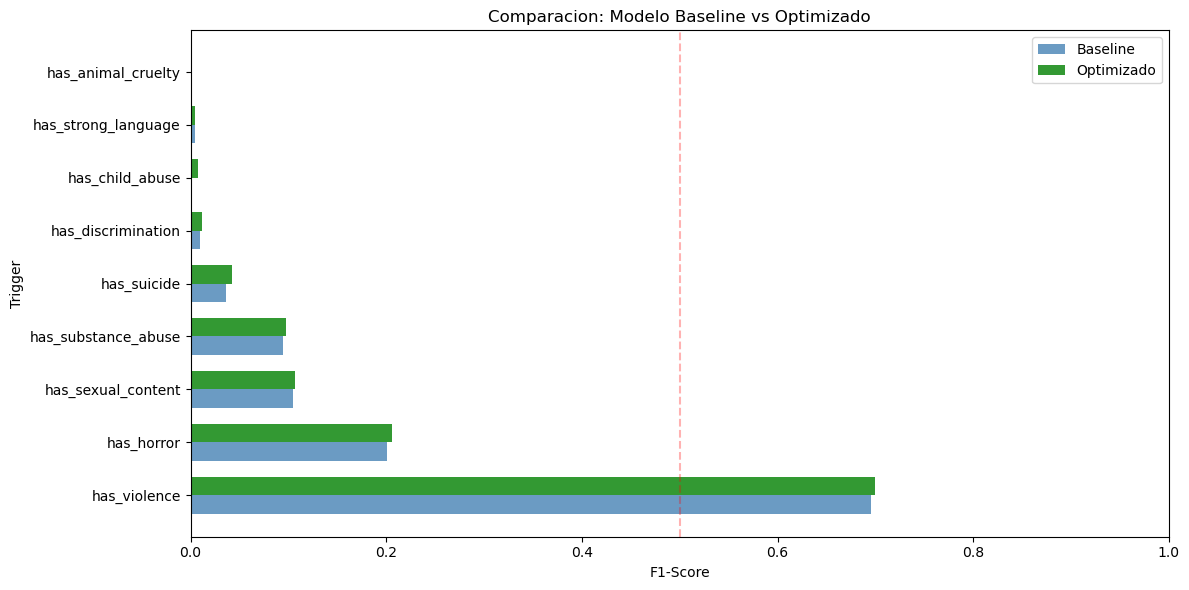

In [77]:
# Visualizar comparacion
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.barh(x - width/2, comparison_df['F1-Score_Baseline'], width, 
                label='Baseline', color='steelblue', alpha=0.8)
bars2 = ax.barh(x + width/2, comparison_df['F1-Score_Optimized'], width, 
                label='Optimizado', color='green', alpha=0.8)

ax.set_ylabel('Trigger')
ax.set_xlabel('F1-Score')
ax.set_title('Comparacion: Modelo Baseline vs Optimizado')
ax.set_yticks(x)
ax.set_yticklabels(comparison_df['Trigger'])
ax.legend()
ax.set_xlim(0, 1)
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## Seccion 12: Conclusiones y Recomendaciones Finales

### Hallazgos Clave

**Desbalanceo de Datos:**
- Violencia: 13.9% (35,760 peliculas) - Ratio 7:1
- Otras categorias: 0.1% - 2.4% - Ratios hasta 1000:1
- Desbalanceo extremo dificulta el aprendizaje de triggers raros

**Modelo Multi-Label:**
- Entrenado exitosamente para las 9 categorias simultaneamente
- Class_weight='balanced' mejora recall en categorias minoritarias
- Triggers frecuentes (violencia, terror, drogas) tienen mejor performance
- Triggers raros (<1%) requieren datos adicionales externos

**Proximo Pasos:**

1. **Corto Plazo:**
   - Mejorar diccionarios de keywords por trigger
   - Experimentar con SMOTE para triggers raros
   - Validacion cruzada estratificada

2. **Mediano Plazo:**
   - Integrar datos externos (DoesTheDogDie, Common Sense Media)
   - Word embeddings en espanol (FastText)
   - Probar XGBoost y modelos ensemble

3. **Produccion:**
   - Implementar arquitectura de 9 modelos independientes
   - Pipeline de procesamiento en background
   - Base de datos para almacenar predicciones
   - API REST para consultas en tiempo real